In [1]:
%load_ext google.cloud.bigquery

In [2]:
import numpy as np 
import pandas as pd
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/shuang/Downloads/bqair-2b59936a9500.json"

# Big query helpers
from google.cloud import bigquery
from bq_helper import BigQueryHelper

# Import plotting libaries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.io as pio
import geopandas
import shapely

# the Plotly in offline mode we can see map in the notebook.
from plotly.offline import download_plotlyjs,init_notebook_mode, plot,iplot
init_notebook_mode(connected=True)

In [3]:
import plotly
plotly.tools.set_credentials_file(username='cleopathy', api_key='Vt9pQQVXJcV8bqHarLVt')

In [4]:
# getting pm25 data:
QUERY = """
    SELECT
        state_code,
        county_code,
        date_local,
        arithmetic_mean,
        state_name,
        county_name,
        aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary`
    WHERE
      poc = 1
      AND EXTRACT(YEAR FROM date_local) in (2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017)
    
        """

In [5]:
bq_assistant = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_pm25 = bq_assistant.query_to_pandas(QUERY) # getting data through big query to pandas
df_pm25['date_local'] = pd.to_datetime(df_pm25['date_local'])
df_pm25['year'] = df_pm25['date_local'].dt.year
df_pm25['month'] = df_pm25['date_local'].dt.month
import calendar
df_pm25['month_name'] = df_pm25['month'].apply(lambda x: calendar.month_abbr[x])
df_pm25['aqi'].fillna(df_pm25['aqi'].mean(), inplace = True)
df_pm25.head()

,state_code,county_code,date_local,arithmetic_mean,state_name,county_name,aqi,year,month,month_name
0,78,030,2007-03-01,3.1,Virgin Islands,St Thomas,13.0,2007,3,Mar
1,78,030,2007-03-25,5.5,Virgin Islands,St Thomas,23.0,2007,3,Mar
2,78,030,2005-12-30,1.6,Virgin Islands,St Thomas,7.0,2005,12,Dec
3,78,030,2005-09-07,0.1,Virgin Islands,St Thomas,0.0,2005,9,Sep
4,78,030,2004-02-09,2.3,Virgin Islands,St Thomas,10.0,2004,2,Feb


In [6]:
df_pm25.info() 
df_pm25.drop_duplicates()
df_pm25.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1844674 entries, 0 to 44673
Data columns (total 10 columns):
state_code         object
county_code        object
date_local         datetime64[ns]
arithmetic_mean    float64
state_name         object
county_name        object
aqi                float64
year               int64
month              int64
month_name         object
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 154.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1844674 entries, 0 to 44673
Data columns (total 10 columns):
state_code         object
county_code        object
date_local         datetime64[ns]
arithmetic_mean    float64
state_name         object
county_name        object
aqi                float64
year               int64
month              int64
month_name         object
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 154.8+ MB


In [7]:
import sklearn 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [9]:
#now we would like to predict AQI of pm25 using sklearn,but now we have to use pandas get dummies and one-hot encoder.

In [10]:
df_pm25['state_name'].value_counts()

California              202037
Pennsylvania            100662
Hawaii                   90342
Indiana                  75614
Florida                  74652
Ohio                     71064
North Carolina           59707
Georgia                  55551
Iowa                     54863
Michigan                 51259
Utah                     44902
New York                 44032
Colorado                 42329
Virginia                 41904
New Jersey               41823
Alabama                  40729
Wyoming                  38880
South Carolina           38788
Illinois                 38690
Tennessee                37970
Louisiana                34117
Texas                    33579
Kentucky                 31761
Massachusetts            28623
Wisconsin                28514
Arkansas                 27097
New Mexico               26487
Nevada                   25776
Connecticut              25011
West Virginia            24834
Maryland                 24457
Missouri                 23677
Oregon  

In [24]:
le = preprocessing.LabelEncoder()

In [25]:
le.fit(df_pm25['state_name'])

LabelEncoder()

In [17]:
list(le.classes_)

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Canada',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District Of Columbia',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Puerto Rico',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virgin Islands',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']

In [26]:
state = le.transform(df_pm25['state_name'])

In [27]:
state

array([48, 48, 48, ..., 40, 40, 40])

In [11]:
sub = df_pm25[['state_code','county_code','aqi','year','month']]
sub.head()

,state_code,county_code,aqi,year,month
0,78,030,13.0,2007,3
1,78,030,23.0,2007,3
2,78,030,7.0,2005,12
3,78,030,0.0,2005,9
4,78,030,10.0,2004,2


In [12]:
sub.aqi = sub.aqi.astype(int)
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1844674 entries, 0 to 44673
Data columns (total 5 columns):
state_code     object
county_code    object
aqi            int64
year           int64
month          int64
dtypes: int64(3), object(2)
memory usage: 84.4+ MB


In [13]:
#now we will encode the year as year is non-numerical data. That way it is easier for us to predict aqi with sklearn machine learning.

In [14]:
def categorical_encoder(df):
    data_original = df[:]
    data_transformed = df[:]
    for i in df.columns:
        if df[i].dtype == object:
            le = preprocessing.LabelEncoder()
            le.fit(df[i])
            data_transformed[i] = le.transform(df[i])
            #original data is le.inverse transform
            data_original[i] = le.inverse_transform(data_transformed[i])
    return data_transformed

In [15]:
new_sub = categorical_encoder(sub)
new_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1844674 entries, 0 to 44673
Data columns (total 5 columns):
state_code     int64
county_code    int64
aqi            int64
year           int64
month          int64
dtypes: int64(5)
memory usage: 84.4 MB


In [16]:
new_sub.aqi = new_sub.aqi.astype(int)
new_sub.head()

,state_code,county_code,aqi,year,month
0,52,17,13,2007,3
1,52,17,23,2007,3
2,52,17,7,2005,12
3,52,17,0,2005,9
4,52,17,10,2004,2


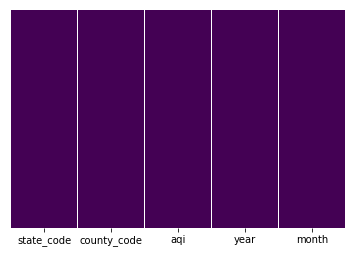

In [17]:
#now let's train the data: we would like to predict aqi 
#first we will see if we would clean the data
import seaborn as sns
import matplotlib as plt
%matplotlib inline
sns.heatmap(new_sub.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')


In [ ]:
cols = ['state_code', 'county_code','aqi','year','month']
sns.pairplot(new_sub[cols],height = 2.5)
plt.tight_layout()
plt.show()